In [1]:
import numpy as np
from sympy.utilities.iterables import multiset_permutations
import matplotlib.pyplot as plt
from tqdm import tqdm

In [56]:
Ns = 4; # number of single-particle states
Ns = 2 * Ns # adjust for spin
Np = 2 # number of fermionic particles

In [57]:
def q(N1, k):
    return np.sum(N1[:k])
def one_el(N1,N2,r,s):
    N1_1 = np.delete(N1, np.array([r,s]))
    N2_1 = np.delete(N2, np.array([r,s]))
    delta = np.all(N1_1 == N2_1)
    dr = 0
    ds = 0
    if r != s:
        if N1[r]-1 == N2[r] :
            dr = 1
        if N1[s] == N2[s]-1 :
            ds = 1
    if r == s:
        if N1[r] == N2[s]:
            dr = 1
            ds = 1
    #print(delta, dr, ds)
    return (N1[r]*((-1)**q(N1,r)))*(N2[s]*((-1)**q(N2,s)))*delta*dr*ds
def two_el(N1, N2, r, s, t, v):
    sig_v = N2[v]*(-1)**q(N2,v)
    N2[v]-=1
    if sig_v != 0:
        sig_t = N2[t]*(-1)**q(N2,t) * sig_v
        N2[t]-=1
        if sig_t != 0:
            sig_s = (1-N2[s])*(-1)**q(N2,s) * sig_t
            N2[s] += 1
            if sig_s != 0:
                sig_r = (1-N2[r])*(-1)**q(N2,r) * sig_s
                N2[r] += 1
                if sig_r != 0 and np.all(N1 == N2):
                    return sig_r
    return 0

def spin(ind):
    if ind < Ns/2:
        return 1
    if ind >= Ns/2:
        return 0
def site(ind):
    if ind < Ns/2:
        return ind
    if ind >= Ns/2:
        return int(ind - Ns/2)
    
site_vec = np.vectorize(site)
print(site_vec(np.arange(Ns)))

[0 1 2 3 0 1 2 3]


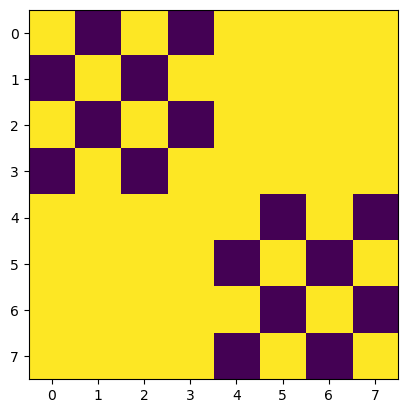

In [58]:
U = 1;
def hub_U(r,s,t,v): # spin off-diagonal, site-diagonal
    sites = site_vec(np.array([r,s,t,v]))
    if len(np.unique(sites)) != 1:
        return 0
    else:
        if spin(r) == spin(t) and spin(s) == spin(v) and spin(r) != spin(s):
            return U
        else:
            return 0
t = 1;
def NN(r,s): 
    if spin(r) == spin(s):
        if r == s + 1:
            return -t
        if r == s - 1:
            return -t
        if s == r + 1:
            return -t
        if s == r - 1:
            return -t
        if s + Ns/2 == r+1:
            return -t
        if r + Ns/2 == s+1:
            return -t
    return 0

def one_el_mat(op):
    out_mat = np.zeros((Ns, Ns), dtype=complex)
    for r in range(Ns):
        for s in range(Ns):
            out_mat[r,s] = op(r,s)
    return out_mat
def two_el_mat(op):
    out_mat = np.zeros((Ns, Ns, Ns, Ns), dtype=complex)
    for r in range(Ns):
        for s in range(Ns):
            for t in range(Ns):
                for v in range(Ns):
                    out_mat[r,s,t,v] = op(r,s,t,v)
    return out_mat
    
NN_mat = one_el_mat(NN)
U_mat = two_el_mat(hub_U)
plt.imshow(np.real(NN_mat))
plt.show()

In [59]:
def S(Np, Ns):
    S0 = np.zeros(Ns,dtype=int)
    S0[:Np] = 1
    return np.array(list(multiset_permutations(S0)))
N1_basis = S(1,Ns)
N2_basis = S(2,Ns)
print(len(N1_basis))

8


In [60]:
def one_el_op(op_mat,basis):
    one_el_mat = np.zeros((len(basis),len(basis)),dtype=complex)
    op_mat_pos = np.where(op_mat != 0.0)
    ran = np.arange(len(basis))
    for n in tqdm(range(len(basis))):
        for m in ran[n:]:
            for pos_n in range(len(op_mat_pos[1])):
                r = op_mat_pos[0][pos_n]
                s = op_mat_pos[1][pos_n]
                one_el_mat[n,m] += one_el(basis[n],basis[m],r,s)*op_mat[r,s]
            one_el_mat[m,n] = np.conjugate(one_el_mat[n,m])
    return one_el_mat

NN_CI_N1_mat = one_el_op(NN_mat,N1_basis)

100%|████████████████████████████████████████████| 8/8 [00:00<00:00, 416.83it/s]


In [76]:
def two_el_av(op_mat, ref):
    Nn = np.shape(ref)[1]
    out1 = np.zeros((Ns, Nn, Ns, Nn),dtype=complex)
    out2 = np.zeros((Ns, Nn, Nn, Ns),dtype=complex)
    for r in range(Ns):
        for mt in range(Nn):
            for t in range(Ns):
                for nt in range(Nn):
                    mel1 = op_mat[r,:,t,:]
                    out1[r,mt,t,nt] = np.dot(np.conjugate(ref[:,mt]),np.dot(mel1,ref[:,nt]))
                    mel2 = op_mat[r,:,:,t]
                    out2[r,mt,nt,t] = np.dot(np.conjugate(ref[:,mt]),np.dot(mel2,ref[:,nt]))
    return out1, out2

def one_el_mf(two_el_av1, two_el_av2):
    out = np.zeros((Ns, Ns), dtype=complex)
    for r in range(Ns):
        for t in range(Ns):
            out[r,t] = 2*np.sum(two_el_av1[r,:,t,:]) - np.sum(two_el_av2[r,:,:,t])
    return out

def get_MF(U_mat, U_ref):
    umat_mf1, umat_mf2 = two_el_av(U_mat, U_ref)
    umat_one_el_mf = one_el_mf(umat_mf1, umat_mf2)
    #U_CI_MF_mat = one_el_op(umat_one_el_mf, N1_basis)
    return umat_one_el_mf

            

In [77]:
e_N1,U_N1 = np.linalg.eigh(NN_CI_N1_mat)
U_ref = U_N1[:,:2] # construct 2 electron reference state 
print(np.shape(U_ref))

(8, 2)


In [79]:
H_MF = NN_CI_N1_mat + get_MF(U_mat, U_ref)
e, U = np.linalg.eigh(H_MF)
